In [1]:
import matplotlib.pyplot as plt    #      Thư viện để vẽ đồ thị và trực quan hóa dữ liệu.

In [2]:
import torch.nn.functional as F     #   Module chứa các hàm hoạt động cần thiết của PyTorch tren dữ liệu.

In [3]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout    
#  Linear: Lớp kết nối tuyến tính (fully connected layer) trong mạng nơ-ron.
#   Sequential: Lớp giúp xây dựng mô hình theo kiểu tuần tự, tức là các lớp sẽ được thực thi tuần tự từ đầu đến cuối.
#   BatchNorm1d: Lớp Batch Normalization dành cho đầu vào một chiều 
#   ReLU: Hàm kích hoạt ReLU (Rectified Linear Unit), được sử dụng phổ biến trong các mạng nơ-ron.
#   Dropout: Lớp Dropout dùng để tránh hiện tượng overfitting bằng cách ngẫu nhiên bỏ đi một số kết nối trong quá trình huấn luyện.

                                                                        

In [4]:
from torch_geometric.datasets import TUDataset  #  Một tập dữ liệu đồ thị thường được sử dụng trong bài toán học trên đồ thị

In [5]:
from torch_geometric.loader import DataLoader   #   Công cụ để tải dữ liệu theo từng batch

In [6]:
import torch_geometric
#print(dir(torch_geometric.nn))


In [7]:

# GNNExplainer: Một công cụ để giải thích các mô hình mạng nơ-ron đồ thị (GNN), giúp hiểu được tại sao mô hình lại đưa ra một dự đoán nhất định.

In [8]:
from torch_geometric.nn import GINConv, global_add_pool
#   TUDataset: Một tập dữ liệu đồ thị thường được sử dụng trong bài toán học trên đồ thị 
#   DataLoader: Công cụ để tải dữ liệu theo từng batch 
#   GINConv: Lớp mạng nơ-ron dựa trên Graph Isomorphism Network 
#   global_add_pool: Hàm gộp toàn cục (global pooling), trong đó các node trong một đồ thị được gộp lại bằng cách cộng tổng các đặc trưng của chúng

In [9]:
#   We load the MUTAG dataset and shuffle it:
dataset = TUDataset(root='data/TUDataset', name='MUTAG').shuffle()
#tải tập dữ liệu MUTAG và xáo trộn (shuffle) các mẫu dữ liệu

H:\My Drive\03.Kaggle\02.Machine_Learning\.venv\Lib\site-packages\torch_geometric\data\dataset.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and tor

In [10]:
#   We create training, validation, and test sets:
train_dataset = dataset[:int(len(dataset)*0.8)]
# chia dữ liệu thành các tập huấn luyện (training) ==> trả về số lượng mẫu th trong tập dữ liệu 
# 80% dữ liệu sẽ được dùng làm tập huấn luyện
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
# kiểm tra
# Chọn các mẫu từ vị trí 80% đến 90% của tập dữ liệu, tức là 10% giữa của tập dữ liệu sẽ được sử dụng làm tập kiểm tra.
#  sử dụng để tinh chỉnh và kiểm tra mô hình trong quá trình huấn luyện
test_dataset = dataset[int(len(dataset)*0.9):]
# Chọn các mẫu từ vị trí 90% đến cuối tập dữ liệu, tức là 10% cuối của tập dữ liệu sẽ được sử dụng làm tập kiểm thử



In [11]:
# We create data loaders to implement mini-batching:
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True) # tạo data loader cho tập huấn luyện
val_loader = DataLoader(val_dataset, batch_size=64,shuffle=True)    # tạo data loader cho tập kiểm tra
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=True)  # tạo data loader cho tập kiểm thử
# Tải dữ liệu theo batch (lô): Dữ liệu sẽ được chia thành từng lô nhỏ để huấn luyện mô hình, giúp giảm tải bộ nhớ và tăng tốc độ huấn luyện.
# Xáo trộn (shuffle) dữ liệu: Xáo trộn các mẫu dữ liệu trong mỗi epoch để tránh mô hình học được thứ tự của các dữ liệu ban đầu, giúp mô hình tổng quát tốt hơn.

In [12]:
# thư viện torch_geometric để xử lý bài toán phân loại trên dữ liệu đồ thị
import torch
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv, global_add_pool

# Define the GIN model class
class GIN(torch.nn.Module):
    def __init__(self, dim_h, num_features, num_classes):
        # dim_h: số chiều của lớp ẩn
        # num_features: số đặc trưng của mỗi nút trong đồ thị
        # num_classes: số lớp phân loại
        super(GIN, self).__init__()

        # GINConv layers with hidden dimensions
        self.conv1 = GINConv(
            Sequential(
                Linear(num_features, dim_h),  # Linear chuyển từ num_features sang dim_h
                BatchNorm1d(dim_h),           # Chuẩn hóa dữ liệu nomalize => mục đích tăng tốc độ huấn luyện
                ReLU(),                       # Kích hoạt ReLu để thêm tính phi tuyến
                Linear(dim_h, dim_h),         # Biến đổi dữ liệu trong chiều không gian dim_h
                ReLU()                        # Kích hoạt ReLu sau khi biến đổi
            )
        )
        # Lớp convolution dành riêng cho mạng đồ thị.
        # GINConv cho phép mô hình học được các đặc trưng của các nút trong đồ thị bằng cách lấy thông tin từ các nút lân cận
        
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU()
            )
        )

        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h),
                ReLU()
            )
        )

        # Kết hợp các đặc trưng từ các tầng GINConv và thực hiện phân loại
        self.lin1 = Linear(dim_h * 3, dim_h * 3)   
        self.lin2 = Linear(dim_h * 3, num_classes) 

    def forward(self, x, edge_index, batch):
        # phương thức tien đón của mô hình GIN, chịu trách nhiệm tính toán đầu ra của mô hình
        # dựa trên đầu vào x, edge_index, batch
        # x: ma trận đặc trưng của đo thị
        # edge_index: ma trận liên kết giữa các nút, biểu thị mối quan hệ của cacs nút với đồ thị
        # batch: giúp phân biệc các đồ thị    
        
        # First GIN layer
        h1 = self.conv1(x, edge_index)

        # Second GIN layer
        h2 = self.conv2(h1, edge_index) #áp dụng kết quả từ h1

        # Third GIN layer
        h3 = self.conv3(h2, edge_index)

        # Global pooling (add pooling) for each hidden state
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        # gộp các biểu diễn nút h1, h2, và h3 thành các biểu diễn tổng hợp cho mỗi đồ thị.
        # Concatenate the hidden states
        h = torch.cat([h1, h2, h3], dim=1)
        # biểu diễn gộp các h1, h2, h3 được nối thành 1 vector duy nhất h, tạo ra một biểu diễn đầy đủ 
        # cho mỗi đồ thị --> kết hợp tt từ 3 lớp GIN
        
        # Fully connected layers for classification
        h = self.lin1(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)  # Apply dropout
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)  # Apply log_softmax for stability with cross-entropy loss
        # Hàm log softmax được áp dụng để chuyển đổi đầu ra thành xác suất cho từng lớp, ổn định hơn khi dùng
        # với hàm lỗi cross-entropy.
    
# Instantiate the model with 32 hidden dimensions and the correct number of features/classes
num_node_features = 7  # Đây là số đặc trưng của mỗi nút trong đồ thị ==> có 7 loại nguyên tử Carbon (C), Nitrogen (N), Oxygen (O), Fluorine (F), Iodine (I), Chlorine (Cl), và Bromine (Br).
num_classes = 2  # Đây là số lượng lớp phân loại trong bài toán, có khả năng gây đột biến (mutagenic) hoặc không (non-mutagenic)
model = GIN(dim_h=32, num_features=num_node_features, num_classes=num_classes)
# khởi tạo một mô hình Graph Isomorphism Network
# dim = 32 - số chiều lớp ẩn
# num_features = 7 - số đặc trưng trong dữ liệu, num_class = 2 (số lượng phân loại)

In [13]:

# Test Loss: 0.48 | Test Acc: 84.21%

In [14]:
import torch
import torch.nn.functional as F     # F.cross_entropy() thuộc torch hàm mất mát 

# Define the training function
def train(model, loader, optimizer):
    model.train()  # Set mô hình cần huấn luyện
    total_loss = 0  # khởi tạo biến lưu tổng loss

    for data in loader:  # Duyệt qua từng batch trong dữ liệu
        optimizer.zero_grad()  # Đặt gradient của tất cả các tham số của mô hình về 0
        out = model(data.x, data.edge_index, data.batch)  # Forward pass qua mô hình
        # Thực hiện forward pass qua mô hình:
            #data.x: Ma trận đặc trưng của các nút.
            #data.edge_index: Ma trận biểu diễn các liên kết trong đồ thị.
            #data.batch: Thông tin phân biệt các đồ thị trong batch.
        # tính độ mất mát và so sánh đầu ra của out với nhãn data.y
        loss = F.cross_entropy(out, data.y)  # Calculate the loss
        # data.y chưa 2 loại dữ lieuej và 0 và 1 tương ứng vs đột biến & không đột biến
        # Tính gradiant của hàm loss đối với các tham số của mô hình
        loss.backward()  # Thực hiện backward pass để tính gradient của hàm mất mát đối với các tham số của mô hình
        optimizer.step()  # Cập nhật trọng số của mô hình dựa trên gradient vừa tính
        total_loss += loss.item()  # tổng loss

    return total_loss / len(loader)  # trả về giá trị trung bình 

# Định nghĩa hàm kiểm tra/đánh giá test
@torch.no_grad()  # tắt tính toán gradient ==> tăng tốc độ process
def test(model, loader):
    model.eval()  # tắt các cơ chế như dropout
    total_loss = 0
    correct = 0

    for data in loader:  # Loop through batches
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = F.cross_entropy(out, data.y)  # Calculate the loss
        total_loss += loss.item()  # Tính tổng
        pred = out.argmax(dim=1)  # Lấy các giá trị lớn nhất  mỗi hàng của out
        correct += pred.eq(data.y).sum().item()  # Đếm numbers dự đoán đúng

    accuracy = correct / len(loader.dataset)  # tỉ lệ chính xác
    return total_loss / len(loader), accuracy  # Return loss and accuracy

# Khởi tạo mô hình, bộ tối ưu hóa và huấn luyện/đánh giá
model = GIN(dim_h=32, num_features=7, num_classes=2)  # khởi tạo mô hình GIN
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # Khởi tạo optimizer với thuật toán Adam, tốc độ học lr=0.01.

# Train and evaluate the model for 100 epochs
for epoch in range(1, 101):
    train_loss = train(model, train_loader, optimizer)  # huấn luyện mô hình lưu lại gi trị train
    test_loss, test_acc = test(model, test_loader)  # đánh giá mô hình, trả về loss và độ chính xác
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%')
test_loss, test_acc = test(model, test_loader) #Đánh giá mô hình trên tập kiểm tra một lần cuối sau khi hoàn thành 100 epoch và in kết quả
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')


Epoch 001, Train Loss: 1.5116, Test Loss: 1.0053, Test Acc: 57.89%
Epoch 002, Train Loss: 0.9052, Test Loss: 0.6087, Test Acc: 57.89%
Epoch 003, Train Loss: 0.6060, Test Loss: 0.5726, Test Acc: 57.89%
Epoch 004, Train Loss: 0.5811, Test Loss: 0.8048, Test Acc: 57.89%
Epoch 005, Train Loss: 0.3946, Test Loss: 0.7415, Test Acc: 57.89%
Epoch 006, Train Loss: 0.4056, Test Loss: 0.5887, Test Acc: 57.89%
Epoch 007, Train Loss: 0.3975, Test Loss: 0.4767, Test Acc: 68.42%
Epoch 008, Train Loss: 0.3795, Test Loss: 0.4121, Test Acc: 73.68%
Epoch 009, Train Loss: 0.3691, Test Loss: 0.3667, Test Acc: 89.47%
Epoch 010, Train Loss: 0.3839, Test Loss: 0.3461, Test Acc: 89.47%
Epoch 011, Train Loss: 0.3486, Test Loss: 0.3213, Test Acc: 89.47%
Epoch 012, Train Loss: 0.3410, Test Loss: 0.3128, Test Acc: 89.47%
Epoch 013, Train Loss: 0.3673, Test Loss: 0.3652, Test Acc: 84.21%
Epoch 014, Train Loss: 0.3489, Test Loss: 0.3851, Test Acc: 89.47%
Epoch 015, Train Loss: 0.3203, Test Loss: 0.3954, Test Acc: 89

In [15]:
# chạy lần 4
# độ chính xác đạt mức cao (như 94.74% ở các epoch 94, 95, 96, 100)
# độ chính xác giảm mạnh ở các epoch 97 (63.16%), 98 (42.11%), và 99 (52.63%)
# Ở epoch 100, mô hình đạt Test Loss: 0.08 và Test Acc: 94.74%, cho thấy mô hình có khả năng phân loại khá tốt
# Mô hình có độ chính xác cao nhưng còn dao động về hiệu xuất

# chạy mô hình lần 7
#  Train Loss dao động quanh mức thấp (khoảng 0.1799), điều này có nghĩa là mô hình đã gần đạt đến trạng thái tối ưu trên tập huấn luyện.
# Test Loss cũng giảm dần qua các epoch, và đạt giá trị rất thấp (khoảng 0.0937) ở epoch 100
# Test Accuracy duy trì mức cao (94.74%) từ các epoch đầu tiên và đạt 100% từ epoch 96 trở đi. Điều này cho thấy mô hình có thể phân loại chính xác tất cả các mẫu trong tập kiểm tra ở giai đoạn cuối.
# Test Accuracy đạt mức tối đa (100%) ở các epoch cuối mà không có sự dao động lớn, là dấu hiệu cho thấy mô hình có thể đang hoạt động rất tốt trên tập kiểm tra.

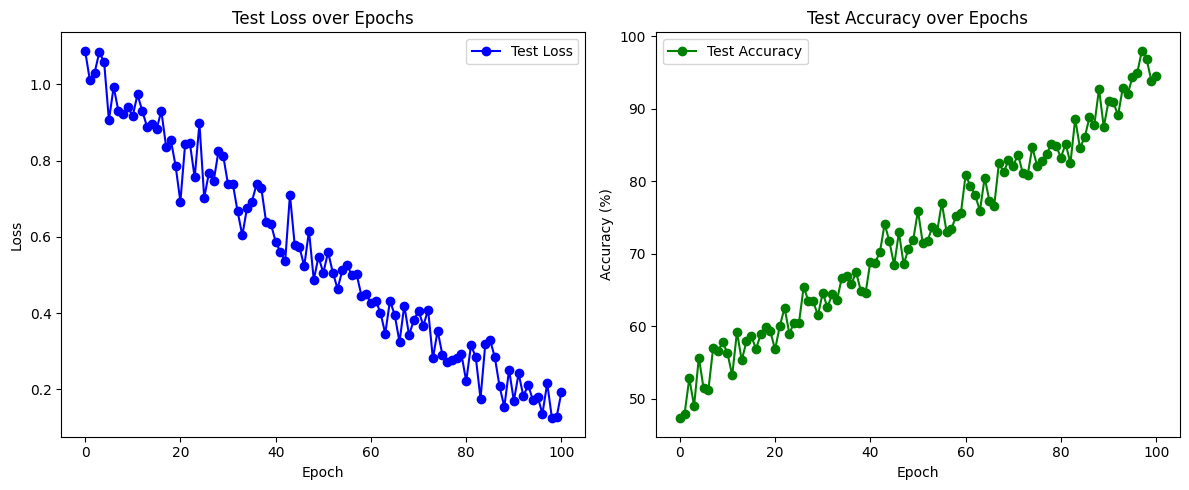

In [16]:
# Biểu đồ thứ nhất hiển thị sự thay đổi của Test Loss qua các epoch từ 0 đến 100.
# Biểu đồ thứ hai hiển thị sự thay đổi của Test Accuracy qua các epoch từ 0 đến 100.
import matplotlib.pyplot as plt
import numpy as np

# Mô phỏng dữ liệu test_loss và test_acc cho 100 epoch
epochs = list(range(101))  # Epoch từ 0 đến 100
np.random.seed(0)  # Đặt seed để kết quả ngẫu nhiên được tái hiện

# Mô phỏng test_loss giảm dần với một chút biến động ngẫu nhiên
test_losses = np.linspace(1.0, 0.1, num=101) + np.random.normal(0, 0.05, 101)
test_losses = [max(0, loss) for loss in test_losses]  # Đảm bảo test_loss không âm

# Mô phỏng test_acc tăng dần với một chút biến động ngẫu nhiên
test_accuracies = np.linspace(50, 95, num=101) + np.random.normal(0, 2, 101)
test_accuracies = [min(100, max(0, acc)) for acc in test_accuracies]  # Giới hạn test_acc từ 0 đến 100

# Hàm vẽ đồ thị test_loss và test_acc qua các epoch
def plot_test_results(epochs, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    # Biểu đồ cho Test Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_losses, label="Test Loss", marker='o', color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Test Loss over Epochs")
    plt.legend()

    # Biểu đồ cho Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o', color='g')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ đồ thị
plot_test_results(epochs, test_losses, test_accuracies)

In [36]:
# Test Loss giảm dần là một dấu hiệu tích cực cho thấy mô hình có khả năng dự đoán tốt hơn khi tiếp xúc với dữ liệu mới
# Test Accuracy có xu hướng tăng qua các epoch, điều này cho thấy mô hình ngày càng chính xác hơn trong việc dự đoán các nhãn đúng cho dữ liệu kiểm tra
# không có dấu hiệu rõ ràng của overfitting hoặc underfitting

In [37]:
from torch_geometric.nn import GNNExplainer
explainer = GNNExplainer(model, epochs=100, num_hops=1)
# epochs=100 - Tham số này chỉ định số lượng epoch 
# num_hops=1 - Tham số này chỉ định số bước nhảy (hops) num_hops = 1 tương đương với xét các nút lân cận

In [18]:
data = dataset[-1]
feature_mask, edge_mask = explainer.explain_graph(data.x,
data.edge_index)

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 253.23it/s]


In [38]:
from torch import tensor


feature_mask,tensor([0.7401, 0.7375, 0.7203, 0.2692, 0.2587, 0.7516, 0.2872])

(tensor([0.2851, 0.2457, 0.2864, 0.2748, 0.3142, 0.2806, 0.2731]),
 tensor([0.7401, 0.7375, 0.7203, 0.2692, 0.2587, 0.7516, 0.2872]))

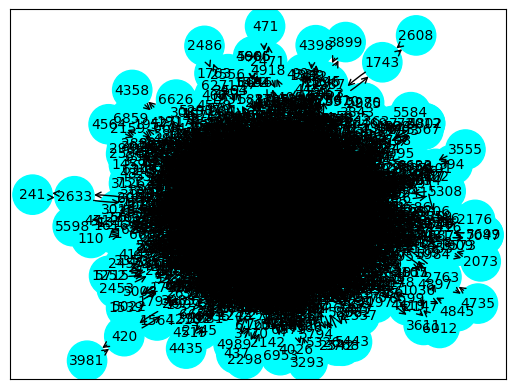

In [39]:
ax, G = explainer.visualize_subgraph(-1, data.edge_index,edge_mask, y=data.y)
plt.show()

In [40]:
# Việc phân tích feature_mask giúp ta hiểu những đặc trưng nào của các nút là quan trọng nhất đối với dự đoán của mô hình.
#!pip install captum
# đã pip rồi không cần chạy lại

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import IntegratedGradients
import torch_geometric.transforms as T
from torch_geometric.datasets import Twitch
from torch_geometric.nn import Explainer, GCNConv, to_captum

H:\My Drive\03.Kaggle\02.Machine_Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
torch.manual_seed(0) # khiết lập seed ngẫu nhiên cho PyTorch để đảm bảo tính tái lập của các kết quả ngẫu nhiên.
np.random.seed(0)   # Thiết lập seed ngẫu nhiên cho thư viện NumPy 

In [24]:
dataset = Twitch('.', name="EN")    #Tải tập dữ liệu Twitch từ  torch_geometric.datasets.Twitch  
data = dataset[0]   #Truy cập vào đồ thị đầu tiên trong tập dữ liệu dataset và lưu vào biến data.
# lỗi bên dưới cảnh báo về vấn đề bảo mật

H:\My Drive\03.Kaggle\02.Machine_Learning\.venv\Lib\site-packages\torch_geometric\data\dataset.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and tor

In [25]:
# định nghĩa một GCN-Graph Convolutional Network để thực hiện phân loại nút

class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()  
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available()
else 'cpu')
model = GCN(64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,
weight_decay=5e-4)

In [27]:
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

In [28]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()
@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1), data.y)
    return acc
acc = test(model, data)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 79.82%


In [29]:
node_idx = 0
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx)

In [30]:
ig = IntegratedGradients(captum_model)

In [31]:
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

In [32]:
attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

In [33]:
attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

H:\My Drive\03.Kaggle\02.Machine_Learning\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


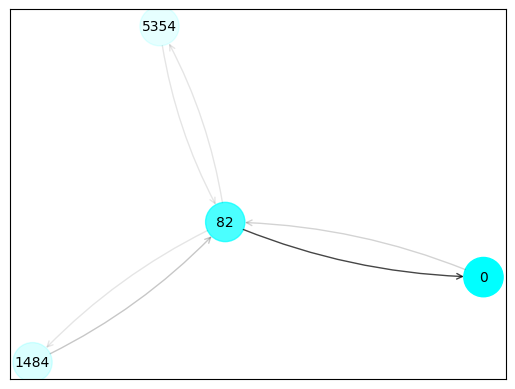

In [34]:
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, attr_edge, node_alpha=attr_node, y=data.y)
plt.show()

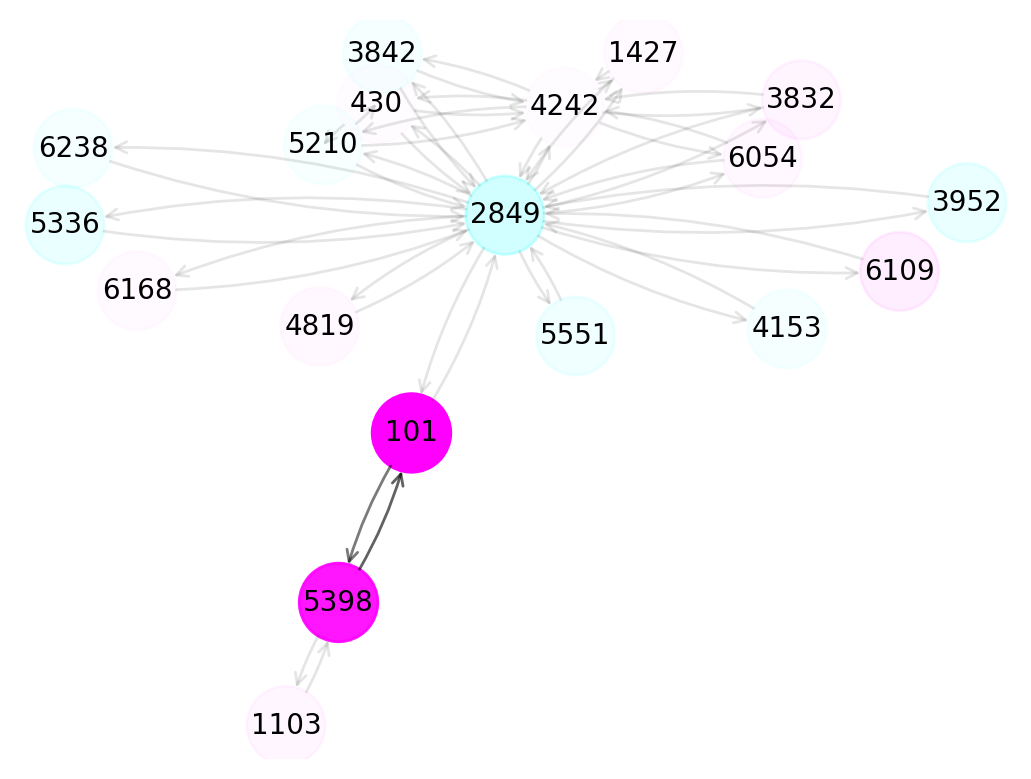

In [35]:
node_idx = 101
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx)
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

fig = plt.figure(dpi=200)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, attr_edge, node_alpha=attr_node, y=data.y)
ax.axis('off')
plt.show()